## IMPORTS

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

In [15]:
plt.rcParams["figure.figsize"] = (20,15)

## DATA ANALYSIS

In [16]:
# Employee subery subset-3
df_emp_survey = pd.read_csv('subset-3-sous-ensemble-3.csv', encoding='ISO-8859-1')

# responses data from dicionary file responses
df_responses = pd.read_excel('2020-pses-supporting-documentation_document-de-reference-du-saff-2020.xlsx', sheet_name='RESPONSE OPTIONS DE RÉPONSES')

df_emp_survey.head()

,LEVEL1ID,LEVEL2ID,LEVEL3ID,LEVEL4ID,LEVEL5ID,SURVEYR,BYCOND,DESCRIP_E,DESCRIP_F,DEMCODE,...,SCORE100,ANSCOUNT,DEPT_E,DEPT_F,INDICATORID,INDICATORENG,INDICATORFRA,SUBINDICATORID,SUBINDICATORENG,SUBINDICATORFRA
0,0,0,0,0,0,2020,Q115 = 1,Male gender,Genre masculin,2011,...,75,73497,Public Service,Fonction publique,4,WORKPLACE,MILIEU DE TRAVAIL,14,Physical environment and equipment,Environnement physique et équipement
1,1,0,0,0,0,2020,Q115 = 1,Male gender,Genre masculin,2011,...,79,11550,Canada Revenue Agency,Agence du revenu du Canada,4,WORKPLACE,MILIEU DE TRAVAIL,14,Physical environment and equipment,Environnement physique et équipement
2,2,0,0,0,0,2020,Q115 = 1,Male gender,Genre masculin,2011,...,80,5626,Employment and Social Development Canada,Emploi et Développement social Canada,4,WORKPLACE,MILIEU DE TRAVAIL,14,Physical environment and equipment,Environnement physique et équipement
3,3,0,0,0,0,2020,Q115 = 1,Male gender,Genre masculin,2011,...,72,7308,Department of National Defence,Ministère de la Défense nationale,4,WORKPLACE,MILIEU DE TRAVAIL,14,Physical environment and equipment,Environnement physique et équipement
4,4,0,0,0,0,2020,Q115 = 1,Male gender,Genre masculin,2011,...,64,3252,Correctional Service Canada,Service correctionnel Canada,4,WORKPLACE,MILIEU DE TRAVAIL,14,Physical environment and equipment,Environnement physique et équipement


### DATA CLEANING

In [17]:
# look at only english columns as french as 'duplicates' of english 
english_columns = [c for c in df_emp_survey.columns if '_F' not in c and c[-3:] != 'FRA']

len(english_columns), len(df_emp_survey.columns) # there are five columns in french, which are not needed

(30, 35)

In [18]:
df_emp_survey = df_emp_survey[english_columns] # only use english columns

In [19]:
# get unique values for each columns
uniq_cols = []
for c in df_emp_survey.columns:
    print(c, ": ", len(df_emp_survey[c].unique()))
    if len(df_emp_survey[c].unique()) > 1:
        uniq_cols.append(c)

LEVEL1ID :  68
LEVEL2ID :  1
LEVEL3ID :  1
LEVEL4ID :  1
LEVEL5ID :  1
SURVEYR :  3
BYCOND :  59
DESCRIP_E :  59
DEMCODE :  59
QUESTION :  216
TITLE_E :  216
ANSWER1 :  102
ANSWER2 :  102
ANSWER3 :  88
ANSWER4 :  72
ANSWER5 :  83
ANSWER6 :  75
ANSWER7 :  66
MOST_POSITIVE_OR_LEAST_NEGATIVE :  103
NEUTRAL_OR_MIDDLE_CATEGORY :  87
MOST_NEGATIVE_OR_LEAST_POSITIVE :  99
AGREE :  103
SCORE5 :  367
SCORE100 :  98
ANSCOUNT :  15719
DEPT_E :  68
INDICATORID :  6
INDICATORENG :  6
SUBINDICATORID :  23
SUBINDICATORENG :  23


### Levels 2-5 ID are all 0

In [20]:
all_levels = df_emp_survey[['LEVEL2ID', 'LEVEL3ID','LEVEL4ID','LEVEL5ID']]
non_zero_rows = len(all_levels[(all_levels != 0).all(axis=1)])
print(f'# rows where level 2-5 are not all empty:   {non_zero_rows}')
all_levels

# rows where level 2-5 are not all empty:   0


,LEVEL2ID,LEVEL3ID,LEVEL4ID,LEVEL5ID
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1405574,0,0,0,0
1405575,0,0,0,0
1405576,0,0,0,0
1405577,0,0,0,0


In [21]:
# only keep columns which don't have static value across all rows
df_emp_survey = df_emp_survey[uniq_cols]

## Delete rows that have no survey data (more than 50%) 1.4M -> 0.8M rows
- Some departments don't have certain equity groups. That means 0 in ANSWER 1-7 for non-exist equity group. 

In [22]:
all_answers = df_emp_survey[['ANSWER1', 'ANSWER2','ANSWER3','ANSWER4', 'ANSWER5', 'ANSWER6', 'ANSWER7']]
answered_rows = all_answers[(all_answers != ' ').all(axis=1)]
unAnswered_rows = all_answers[(all_answers == ' ').all(axis=1)]
set3_cleaned = df_emp_survey.iloc[answered_rows.index]
print(f'# rows that has no ANSWER 1-7:   {len(unAnswered_rows)}')
answered_rows
df_emp_survey.iloc[unAnswered_rows.index].head()

# remove empty records
df_emp_survey = df_emp_survey.query("ANSCOUNT != ' '")

# rows that has no ANSWER 1-7:   822456


### Conver Numeric type columns to int

In [27]:
for i in ['ANSWER1','ANSWER2','ANSWER3','ANSWER4','ANSWER5','ANSWER6','ANSWER7', 'ANSCOUNT','MOST_POSITIVE_OR_LEAST_NEGATIVE','NEUTRAL_OR_MIDDLE_CATEGORY','MOST_NEGATIVE_OR_LEAST_POSITIVE']:
    df_emp_survey[i] = df_emp_survey[i].astype(int)

In [28]:
# Some of these percenatages are off, by very little
df_emp_survey.eval('ANSWER1 + ANSWER2 + ANSWER3 + ANSWER4 + ANSWER5 + ANSWER6 + ANSWER7')

0          100
1          101
2          100
3           99
4           98
          ... 
1405574    101
1405575    100
1405576    101
1405577    100
1405578     99
Length: 583123, dtype: int32

## Demographic Groups: 
- We have 59 demograohic groups
- This include non selected groups: eg. "Chinese" vs. "Chinese - Not selected"

In [23]:
# There are 59 equity groups
print(f'We have {len(df_emp_survey.DESCRIP_E.unique())} demographic groups')
list(df_emp_survey.DESCRIP_E.unique())

We have 59 demographic groups


['Male gender',
 'Female gender',
 'Gender diverse',
 'Indigenous',
 'Non-Indigenous',
 'First Nation (North American Indian)',
 'Métis',
 'Inuk (Inuit)',
 'Person with a disability',
 'Not a person with a disability',
 'A seeing disability affects vision, including total blindness, partial sight and visual distortion',
 'A seeing disability affects vision, including total blindness, partial sight and visual distortion - Not selected',
 'A hearing disability affects ability to hear, including being hard of hearing, deafness or acoustic distortion',
 'A hearing disability affects ability to hear, including being hard of hearing, deafness or acoustic distortion - Not selected',
 'A mobility issue affects ability to move your body, including the required use of a wheelchair or a cane, or other issues impacting your mobility',
 'A mobility issue affects ability to move your body, including the required use of a wheelchair or a cane, or other issues impacting your mobility - Not selected',


In [35]:
# Try to group all demographic groups into more general categories

df_emp_survey['BYCOND_1'] = df_emp_survey['BYCOND'].str.split("=").str[0] # take left side of by cond column e.g (Q115=1) -> (Q115)

df_emp_survey['BYCOND_2'] = df_emp_survey['BYCOND'].str.split("=").str[0].str.extract('(Q[0-9]+)') # take only the demo code no letter e.g. (Q121a) -> (Q121)

uniq_by_cond = df_emp_survey['BYCOND_1'].unique()
uniq_by_cond_2 = df_emp_survey['BYCOND_2'].unique()

In [37]:
ans_cols = ['ANSWER1','ANSWER2','ANSWER3','ANSWER4','ANSWER5','ANSWER6','ANSWER7']

In [36]:
# COND_2 is more general than COND_1. democode -> (Q121A = 2) and cond_2 -> (Q121) this helps us group more categories
dict_demograph_2 = {}
for c in uniq_by_cond_2:
    dict_demograph_2[c] = list(df_emp_survey.query(f"BYCOND_2 == '{c}'")['DESCRIP_E'].unique())

## Columns added
- GENERAL_DEMO_GROUP
- SELECTED

In [38]:
# added column 'GENERAL_DEMO_GROUP': The list below w.r.t. 'BYCOND2' 
general_demo = ['gender', 'indigenous', 'indigenous-specified', 
                'person with disability', 'person with disability-specified', 
                'visible minority', 'ethnicity', 'sexuality']

general_demo_dict = {}
index = 0
for code in dict_demograph_2.keys():
    general_demo_dict[code] = general_demo[index]
    index+=1
general_demo_list = [general_demo_dict[group] for group in df_emp_survey['BYCOND_2']]
df_emp_survey['GENERAL_DEMO_GROUP'] = general_demo_list

In [42]:
# added column 'SELECTED': True/False 
# eg. 'Chinese' is True, 'Chinese - Not selected' is False
selected = ['selected' if 'Not selected' not in group else 'not selected' for group in df_emp_survey['DESCRIP_E']]
df_emp_survey['SELECTED'] = selected

## PROBLEM ANALYSIS & VISUALIZATION

To narrow down the list of question, we are focusing on some of the topics that we think affect minorities more


In [43]:
important_subindicators = ['Pay or other compensation issues','Discrimination','A psychologically healthy workplace','Harassment',
                            'Diversity and inclusion', 'Anti-racism', 'Immediate supervisor','Job fit and development','Mobility and Retention','Employee Engagement']

df_qa = df_emp_survey.query(f'SUBINDICATORENG in {important_subindicators}')

# # Lets subgroup by subindicator and title only pick top two questions with most answer count
# df_qa = df_qa.groupby(['INDICATORENG','SUBINDICATORENG','TITLE_E']).max()[['ANSCOUNT']].reset_index()
# df_qa.sort_values('ANSCOUNT', ascending=False).groupby("SUBINDICATORENG").head(2)


# Lets subgroup by subindicator and title only pick top any two questions
df_qa = df_qa.groupby(['INDICATORENG','SUBINDICATORENG','TITLE_E']).max()[['ANSCOUNT']].reset_index()
df_qa.sort_values('ANSCOUNT', ascending=False).groupby("SUBINDICATORENG").head(2)

,INDICATORENG,SUBINDICATORENG,TITLE_E,ANSCOUNT
0,COMPENSATION,Pay or other compensation issues,"Question 93. In the last 12 months, has your p...",179243
21,WORKFORCE,Mobility and Retention,Question 53. Do you intend to leave your curre...,179198
17,WORKFORCE,Job fit and development,Question 43a. To what extent have the followin...,179069
12,LEADERSHIP,Immediate supervisor,Question 30. I am satisfied with the quality o...,179044
82,WORKPLACE,Harassment,Question 55. Having carefully read the definit...,178982
16,WORKFORCE,Job fit and development,Question 42. I believe I have opportunities fo...,178940
2,COMPENSATION,Pay or other compensation issues,Question 97. To what extent have issues with t...,178878
9,EMPLOYEE ENGAGEMENT,Employee Engagement,Question 7. I get a sense of satisfaction from...,178870
5,EMPLOYEE ENGAGEMENT,Employee Engagement,"Question 16. Overall, I like my job.",178826
133,WORKPLACE WELL-BEING,A psychologically healthy workplace,Question 78. I would describe my workplace as ...,178818


In [44]:
# get actual responses for each question
def get_responses(q):
    return df_responses.query(f"QUESTION == '{q}'")[['Answer1ENG','Answer2ENG','Answer3ENG','Answer4ENG','Answer5ENG','Answer6ENG','Answer7ENG']].values[0]

# get demographic codes for each question
def get_demo_descrip(demo_codes):
    dict_codes = {}
    for i in demo_codes:
        dict_codes[i] = df_emp_survey.query(f"BYCOND == '{i}'")['DESCRIP_E'].iloc[0]
    return dict_codes

# get data frame results for a question
def get_results(q, demo_code):
    # get men, women and gender diverse answer pools for a question on average across all dept
    idx_cols = get_demo_descrip(df_emp_survey.query(f"BYCOND_2 == '{demo_code}' and QUESTION == '{q}'").groupby('BYCOND').mean()[ans_cols+['MOST_POSITIVE_OR_LEAST_NEGATIVE','NEUTRAL_OR_MIDDLE_CATEGORY','MOST_NEGATIVE_OR_LEAST_POSITIVE']].index)
    df_resp_score = df_emp_survey.query(f"BYCOND_2 == '{demo_code}' and QUESTION == '{q}'").groupby('BYCOND').mean()[ans_cols]
    responses = get_responses(q)

    # replace values
    df_resp_score.rename(index=idx_cols, inplace=True)
    df_resp_score.columns = responses

    return df_resp_score

In [45]:
# Number of questions by Indicatior and SubIndicator
df_tree_map = df_emp_survey.groupby(['INDICATORENG','SUBINDICATORENG','DESCRIP_E'])[['QUESTION']].count().reset_index()

fig = px.treemap(df_tree_map, path=[px.Constant("Question Types"), 'INDICATORENG', 'SUBINDICATORENG'], values='QUESTION', color='QUESTION'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

## Questions

### Question 74. My department or agency does a good job of raising awareness of mental health in the workplace.


In [47]:

# show the above distribution for Each demographic group, with the question asked. and their responses
print(df_emp_survey.query("QUESTION == 'Q74'")['TITLE_E'].iloc[0])
df_tree_map = df_emp_survey.query("QUESTION == 'Q74'").groupby(['SELECTED','GENERAL_DEMO_GROUP','DESCRIP_E'])['ANSWER5'].mean().reset_index()
df_tree_map = df_tree_map.query("SELECTED == 'selected'")
df_tree_map.rename(columns={'ANSWER5': 'Strongly disagree'}, inplace=True)

Question 74. My department or agency does a good job of raising awareness of mental health in the workplace.


In [48]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant(df_emp_survey.query("QUESTION == 'Q74'")['TITLE_E'].iloc[0]), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values=df_tree_map.columns[-1], color=df_tree_map.columns[-1]
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Question 76. I would feel comfortable sharing concerns with my immediate supervisor about my mental health.


In [49]:
# show the above distribution for Each demographic group, with the question asked. and their responses
print(df_emp_survey.query("QUESTION == 'Q76'")['TITLE_E'].iloc[0])
df_tree_map = df_emp_survey.query("QUESTION == 'Q76'").groupby(['SELECTED','GENERAL_DEMO_GROUP','DESCRIP_E'])['ANSWER5'].mean().reset_index()
df_tree_map = df_tree_map.query("SELECTED == 'selected'")
df_tree_map.rename(columns={'ANSWER5': 'Strongly disagree'}, inplace=True)

Question 76. I would feel comfortable sharing concerns with my immediate supervisor about my mental health.


In [50]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant(df_emp_survey.query("QUESTION == 'Q76'")['TITLE_E'].iloc[0]), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values=df_tree_map.columns[-1], color=df_tree_map.columns[-1]
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Question 23. In my work unit, I would feel free to speak about racism in the workplace without fear of reprisal.


In [51]:
# show the above distribution for Each demographic group, with the question asked. and their responses
print(df_emp_survey.query("QUESTION == 'Q23'")['TITLE_E'].iloc[0])
df_tree_map = df_emp_survey.query("QUESTION == 'Q23'").groupby(['SELECTED','GENERAL_DEMO_GROUP','DESCRIP_E'])['ANSWER5'].mean().reset_index()
df_tree_map = df_tree_map.query("SELECTED == 'selected' and GENERAL_DEMO_GROUP == 'ethnicity'")
df_tree_map.rename(columns={'ANSWER5': 'Strongly disagree'}, inplace=True)

Question 23. In my work unit, I would feel free to speak about racism in the workplace without fear of reprisal.


In [52]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant(df_emp_survey.query("QUESTION == 'Q23'")['TITLE_E'].iloc[0]), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values=df_tree_map.columns[-1], color=df_tree_map.columns[-1]
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Question 47. My department or agency implements initiatives that promote anti-racism in the workplace.


In [53]:
# show the above distribution for Each demographic group, with the question asked. and their responses
print(df_emp_survey.query("QUESTION == 'Q47'")['TITLE_E'].iloc[0])
df_tree_map = df_emp_survey.query("QUESTION == 'Q47'").groupby(['SELECTED','GENERAL_DEMO_GROUP','DESCRIP_E'])['ANSWER5'].mean().reset_index()
df_tree_map = df_tree_map.query("SELECTED == 'selected' and GENERAL_DEMO_GROUP == 'ethnicity'")
df_tree_map.rename(columns={'ANSWER5': 'Strongly disagree'}, inplace=True)

Question 47. My department or agency implements initiatives that promote anti-racism in the workplace.


In [54]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant(df_emp_survey.query("QUESTION == 'Q47'")['TITLE_E'].iloc[0]), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values=df_tree_map.columns[-1], color=df_tree_map.columns[-1]
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Question 62. Having carefully read the definition of discrimination, have you been the victim of discrimination on the job in the past 12 months?


In [56]:
# show the above distribution for Each demographic group, with the question asked. and their responses
print(df_emp_survey.query("QUESTION == 'Q62'")['TITLE_E'].iloc[0])
df_tree_map = df_emp_survey.query("QUESTION == 'Q62'").groupby(['SELECTED','GENERAL_DEMO_GROUP','DESCRIP_E'])['ANSWER1'].mean().reset_index()
df_tree_map = df_tree_map.query("SELECTED == 'selected'")
df_tree_map.rename(columns={'ANSWER1': 'Yes'}, inplace=True)

Question 62. Having carefully read the definition of discrimination, have you been the victim of discrimination on the job in the past 12 months?


In [57]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant(df_emp_survey.query("QUESTION == 'Q62'")['TITLE_E'].iloc[0]), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values=df_tree_map.columns[-1], color=df_tree_map.columns[-1]
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Q55. have you been the victim of harassment on the job in the past 12 months?

In [60]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q55'").groupby(['SELECTED','GENERAL_DEMO_GROUP','DESCRIP_E'])[['DESCRIP_E','ANSWER1','ANSWER2']].mean().reset_index()
df_tree_map = df_tree_map.query("SELECTED == 'selected'")
df_tree_map.rename(columns={'ANSWER1': 'Yes', 'ANSWER2':'No'}, inplace=True)
# df_tree_map = df_emp_survey[].groupby(['INDICATORENG','BYCOND_2','BYCOND_1'])[['ANSWER1','ANSWER2','ANSWER3','ANSWER4','ANSWER5']].count().reset_index()

In [61]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant("Q55 have you been the victim of harassment on the job in the past 12 months?"), 
                                    'SELECTED','GENERAL_DEMO_GROUP', 'DESCRIP_E'], values='Yes', color='Yes'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Q56 a-g From whom did you experience harassment on the job?
- Co-workers
- Individuals with authority over me
- Individuals working for me
- Individuals for whom I have a custodial responsibility (e.g., inmates, offenders, patients, detainees)
- Individuals from other departments or agencies
- Members of the public (individuals or organizations)
- Other

In [63]:
harassment_src = ['Co-workers', 'Individuals with authority over me', 
                  'Individuals working for me','Individuals for whom I have a custodial responsibility', 
                  'Individuals from other departments or agencies', 
                  'Members of the public (individuals or organizations)', 
                  'Other']

In [64]:
df_emp_survey.query("QUESTION == 'Q56a'").groupby('BYCOND_1').mean()
df_tree_map = df_emp_survey.query("QUESTION == 'Q56a' or QUESTION == 'Q56b' or QUESTION == 'Q56c' or QUESTION == 'Q56d' or QUESTION == 'Q56e' or QUESTION == 'Q56f' or QUESTION == 'Q56g'").groupby(['QUESTION'])[['ANSWER1','ANSWER2']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Yes', 'ANSWER2':'No'}, inplace=True)
df_tree_map['SOURCE'] = harassment_src
df_tree_map

,QUESTION,Yes,No,SOURCE
0,Q56a,48.784031,51.215969,Co-workers
1,Q56b,62.554353,37.446162,Individuals with authority over me
2,Q56c,6.993308,93.006692,Individuals working for me
3,Q56d,2.464286,97.535714,Individuals for whom I have a custodial respon...
4,Q56e,5.901099,94.098901,Individuals from other departments or agencies
5,Q56f,10.123616,89.876384,Members of the public (individuals or organiza...
6,Q56g,4.075978,95.924022,Other


In [65]:
fig = px.treemap(df_tree_map, path=[px.Constant(" Q56 From whom did you experience harassment on the job?"), 
                                    'SOURCE'], values='Yes', color='Yes'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()
# plt.bar(df_tree_map['SOURCE'], df_tree_map['Yes'])
# plt.xticks(rotation=90)

### Q57 a-m. Please indicate the nature of the harassment you experienced


In [66]:
harassment_nature = ['Aggressive behaviour',
                     'Excessive control',
                     'Being excluded or being ignored',
                     'Humiliation',
                     'Interference with work or withholding resources',
                     'Offensive remark',
                     'Personal attack',
                     'Physical violence',
                     'Sexual comment or gesture',
                     'Threat',
                     'Unfair treatment',
                     'Yelling or shouting',
                     'Other']

In [68]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q57a' or QUESTION == 'Q57b' or QUESTION == 'Q57c' or QUESTION == 'Q57d' or QUESTION == 'Q57e' or QUESTION == 'Q57f' or QUESTION == 'Q57g' or QUESTION == 'Q57h' or QUESTION == 'Q57i' or QUESTION == 'Q57j' or QUESTION == 'Q57k' or QUESTION == 'Q57l' or QUESTION == 'Q57m' and SELECTED=='selected'").groupby(['QUESTION'])[['ANSWER1','ANSWER2']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Yes', 'ANSWER2':'No'}, inplace=True)
df_tree_map['NATURE'] = harassment_nature
df_tree_map.sort_values(by='Yes',ascending=False).head()

,QUESTION,Yes,No,NATURE
5,Q57f,53.609519,46.390966,Offensive remark
10,Q57k,52.124205,47.875795,Unfair treatment
2,Q57c,48.869820,51.130180,Being excluded or being ignored
3,Q57d,43.909358,56.090642,Humiliation
1,Q57b,42.444499,57.555501,Excessive control


In [69]:
fig = px.treemap(df_tree_map, path=[px.Constant("the nature of the harassment you experienced?"), 
                                    'NATURE'], values='Yes', color='Yes'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Q53. Do you intend to leave your current position in the next two years?


In [70]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q53' and SELECTED=='selected'").groupby(['GENERAL_DEMO_GROUP','DESCRIP_E'])[['ANSWER1','ANSWER2', 'ANSWER3']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Yes', 'ANSWER2':'No', 'ANSWER3':'Not Sure'}, inplace=True)
df_tree_map.head()

,GENERAL_DEMO_GROUP,DESCRIP_E,Yes,No,Not Sure
0,ethnicity,Black,34.247788,26.557522,39.123894
1,ethnicity,Chinese,23.585106,37.617021,38.765957
2,ethnicity,Filipino,23.189655,37.293103,39.568966
3,ethnicity,Japanese,27.071429,33.250000,39.785714
4,ethnicity,Korean,27.342857,31.685714,41.085714


About the same pct of people selected Yes, No and Not sure

C:\Users\Qasim\AppData\Local\Temp/ipykernel_19112/531491799.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Text(0.5, 1.0, 'Do you intend to leave your current position in the next two years?')

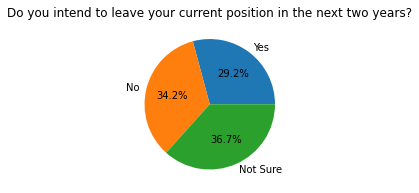

In [71]:
all_choice_mean = df_tree_map.mean().to_dict()
plt.figure(figsize=(3,3))
plt.pie(all_choice_mean.values(),labels=[*all_choice_mean], autopct='%1.1f%%')
plt.title('Do you intend to leave your current position in the next two years?')

In [72]:
fig = px.treemap(df_tree_map, path=[px.Constant("Q53 Intention to leave current position in the next two years - YES"), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values='Yes', color='Yes'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Q54. Please indicate your reason for leaving.

In [76]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q54' and SELECTED=='selected'").groupby(['GENERAL_DEMO_GROUP','DESCRIP_E'])[['ANSWER1','ANSWER2', 'ANSWER3', 'ANSWER4', 'ANSWER5', 'ANSWER6']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1':'To retire', 'ANSWER2':'To pursue another position within my department or agency', 
                            'ANSWER3':'To pursue a position in another department or agency', 
                            'ANSWER4':'To pursue a position outside the federal public service', 
                            'ANSWER5':'End of my term, casual or student employment', 
                            'ANSWER6':'Other'}, inplace=True)
df_tree_map.head()

,GENERAL_DEMO_GROUP,DESCRIP_E,To retire,To pursue another position within my department or agency,To pursue a position in another department or agency,To pursue a position outside the federal public service,"End of my term, casual or student employment",Other
0,ethnicity,Black,3.718310,35.830986,39.028169,4.605634,9.985915,6.845070
1,ethnicity,Chinese,6.981132,32.339623,33.943396,4.547170,17.716981,4.622642
2,ethnicity,Filipino,6.125000,34.291667,36.375000,3.416667,14.875000,4.833333
3,ethnicity,Japanese,23.000000,28.000000,14.666667,6.333333,15.333333,13.000000
4,ethnicity,Korean,1.714286,42.285714,36.857143,6.571429,8.000000,4.714286


C:\Users\Qasim\AppData\Local\Temp/ipykernel_19112/4271289635.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Text(0.5, 1.0, 'Reason for Leaving')

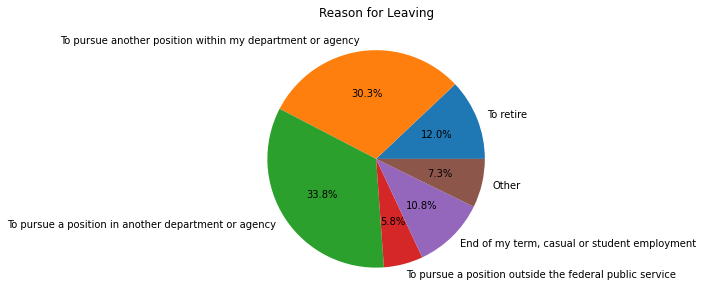

In [77]:
leave_choices = df_tree_map.mean().to_dict()
choices = leave_choices.keys()
pct = leave_choices.values()
plt.figure(figsize=(5,5))
plt.pie(pct, labels = choices, autopct='%1.1f%%')
plt.title('Reason for Leaving')

### Q26. I feel that my immediate supervisor supports my career goals.


In [79]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q24'").groupby(['SELECTED','GENERAL_DEMO_GROUP','DESCRIP_E'])[['ANSWER1','ANSWER2', 'ANSWER3', 'ANSWER4', 'ANSWER5']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1':'Strongly Agree', 
                            'ANSWER2':'Somewhat Agree', 
                            'ANSWER3':'Neither agree nor disagree', 
                            'ANSWER4':'Somewhat Disagree', 
                            'ANSWER5':'Strongly Disagree'}, inplace=True)
df_tree_map['Disagree'] = df_tree_map['Somewhat Disagree'] + df_tree_map['Somewhat Disagree']
df_tree_map.describe()

,Strongly Agree,Somewhat Agree,Neither agree nor disagree,Somewhat Disagree,Strongly Disagree,Disagree
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,47.072721,24.773840,13.700201,5.020126,4.256780,10.040252
std,3.534192,1.597598,1.549782,0.954519,1.330853,1.909038
min,35.722222,18.357143,10.600000,3.241379,2.265152,6.482759
25%,45.332819,23.919974,12.455291,4.389474,3.461993,8.778947
50%,47.000000,24.870968,13.885496,5.142857,4.040000,10.285714
75%,48.649178,25.384840,14.334133,5.746875,5.077006,11.493750
max,53.431818,29.000000,18.000000,7.250000,9.333333,14.500000


In [81]:
fig = px.treemap(df_tree_map, path=[px.Constant("Q53 I feel that my immediate supervisor supports my career goals - DISAGREE"), 
                                    'SELECTED','GENERAL_DEMO_GROUP', 'DESCRIP_E'], values='Disagree', color='Disagree'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### 62(J)

In [82]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q62' and SELECTED=='selected'").groupby(['GENERAL_DEMO_GROUP','DESCRIP_E'])[['DESCRIP_E','ANSWER1','ANSWER2']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Yes', 'ANSWER2':'No'}, inplace=True)

In [84]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant("Question 62. Having carefully read the definition of discrimination, have you been the victim of discrimination on the job in the past 12 months?"), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values='Yes', color='Yes'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()


### Q63 a-g Discrimination come from
 
- Co-workers
- Individuals with authority over me
- Individuals working for me
- Individuals for whom I have a custodial responsibility (e.g., inmates, offenders, patients, detainees)
- Individuals from other departments or agencies
- Members of the public (individuals or organizations)
- Other

In [85]:
Discrimination_src = ['Co-workers', 'Individuals with authority over me', 
                  'Individuals working for me','Individuals for whom I have a custodial responsibility', 
                  'Individuals from other departments or agencies', 
                  'Members of the public (individuals or organizations)', 
                  'Other']

In [87]:
df_emp_survey.query("QUESTION == 'Q63a'").groupby('BYCOND_1').mean()
df_tree_map = df_emp_survey.query("QUESTION == 'Q63a' or QUESTION == 'Q63b' or QUESTION == 'Q63c' or QUESTION == 'Q63d' or QUESTION == 'Q63e' or QUESTION == 'Q63f' or QUESTION == 'Q63g' and SELECTED=='selected'").groupby(['QUESTION'])[['ANSWER1','ANSWER2']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Yes', 'ANSWER2':'No'}, inplace=True)
df_tree_map['SOURCE'] = Discrimination_src
df_tree_map

,QUESTION,Yes,No,SOURCE
0,Q63a,38.847141,61.152859,Co-workers
1,Q63b,75.361464,24.638536,Individuals with authority over me
2,Q63c,3.550765,96.449235,Individuals working for me
3,Q63d,1.467460,98.532540,Individuals for whom I have a custodial respon...
4,Q63e,8.138202,91.861798,Individuals from other departments or agencies
5,Q63f,10.201912,89.798088,Members of the public (individuals or organiza...
6,Q63g,8.642647,91.357353,Other


In [88]:
fig = px.treemap(df_tree_map, path=[px.Constant("Question 63a. From whom did you experience discrimination on the job?"),'SOURCE'], values='Yes', color='Yes'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()
# plt.bar(df_tree_map['SOURCE'], df_tree_map['Yes'])
# plt.xticks(rotation=90)

In [91]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q63b' and SELECTED=='selected'").groupby(['GENERAL_DEMO_GROUP','DESCRIP_E'])[['DESCRIP_E','ANSWER1','ANSWER2']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Yes', 'ANSWER2':'No'}, inplace=True)

In [92]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant("Question 63b. From whom did you experience discrimination on the job? Individuals with authority over me"), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values='Yes', color='Yes'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Diversity and inclusion - 21

In [94]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q21' and SELECTED=='selected'").groupby(['GENERAL_DEMO_GROUP','DESCRIP_E'])[['DESCRIP_E','ANSWER1','ANSWER2','ANSWER3','ANSWER4','ANSWER5']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Strongly agree', 'ANSWER2':'Somewhat agree','ANSWER3':'Neither agree nor disagree','ANSWER4':'Somewhat disagree','ANSWER5':'Strongly disagree'}, inplace=True)

In [95]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant("Question 21. In my work unit, individuals behave in a respectful manner."), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values='Strongly agree', color='Strongly agree'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Employee engagement - 11

In [97]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q11' and SELECTED=='selected'").groupby(['GENERAL_DEMO_GROUP','DESCRIP_E'])[['DESCRIP_E','ANSWER1','ANSWER2','ANSWER3','ANSWER4','ANSWER5']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Strongly agree', 'ANSWER2':'Somewhat agree','ANSWER3':'Neither agree nor disagree','ANSWER4':'Somewhat disagree','ANSWER5':'Strongly disagree'}, inplace=True)

In [99]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant("Question 11. Overall, I feel valued at work."), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values='Strongly agree', color='Strongly agree'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Question 12

In [103]:
df_tree_map = df_emp_survey.query("QUESTION == 'Q12' and SELECTED=='selected'").groupby(['GENERAL_DEMO_GROUP','DESCRIP_E'])[['DESCRIP_E','ANSWER1','ANSWER2','ANSWER3','ANSWER4','ANSWER5']].mean().reset_index()
df_tree_map.rename(columns={'ANSWER1': 'Strongly agree', 'ANSWER2':'Somewhat agree','ANSWER3':'Neither agree nor disagree','ANSWER4':'Somewhat disagree','ANSWER5':'Strongly disagree'}, inplace=True)

In [104]:
# Number of questions by Indicatior and SubIndicator

fig = px.treemap(df_tree_map, path=[px.Constant("Question 12. I am proud of the work that I do."), 
                                    'GENERAL_DEMO_GROUP', 'DESCRIP_E'], values='Strongly agree', color='Strongly agree'
                                    ,color_continuous_scale='GnBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()